# Experimenting with the HathiTrust Corpus & Machine Learning

This notebook is based on the [Classifying HTRC Genre notebook](https://github.com/htrc/ACS-TT/blob/master/tools/notebooks/ClassifyingHtrcGenreWordFrequencies.ipynb) and uses data from the [HathiTrust Research Center](https://sharc.hathitrust.org/genre). A few caveats about the provenance and method of selection of the data:
- only English
- texts published 1700-1799, but may include reprints of earlier materials
- volumes held by large public or university libraries, primarily in the United States.
- the creators don't recommend the dataset as a source for literary research before 1750, since texts published pre-1800 is often in Special Collections and digitization is less predictable.
- A short version: the model's predictions about genre matched human descriptions 93.6% of the time, which is roughly as often as our six human readers agreed with each other (94.5%). Moreover, the datasets provided here have passed through additional (automatic and manual) filtering that allows us to guarantee better than 97% precision.

See the HathiTrust Research Center for more observations on normalization, OCR correction, metadata, and more.

All right, let's set up our classifier:

The first step is to (re)build our philosophical classifier. It's worth reiterating that the classifier is being trained on a relatively small corpus (so isn't likely as representative as it might be) and that the new HTRC genre corpus is literature-specific (so a different kind of beast from our training corpus). Is it still useful as a classifier? that's part of what we'd like to find out.
The classifier created below is essentially the same as before, though we'll use the LinearSVC algorithm because it provides a way of not just classifying (philosophical or non-philosophical) but also of expressing a value for how philosophical or not the text is.

In [6]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# define the training corpus to use 
trav_data_dir = "C:/Users/broomgrass/iPython/Dream/data/texts"
trav_corpus = nltk.corpus.reader.plaintext.PlaintextCorpusReader(trav_data_dir+"/modcorpus", ".*\.txt")
filtered_fileids = [fileid for fileid in trav_corpus.fileids()]

# create TF-IDF (actually relative frequencies) vectorizer
stopword_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=10000)
X_train = stopword_vectorizer.fit_transform([trav_corpus.raw(fileid) for fileid in filtered_fileids])
trav_categories = ["Other" if "Other" in fileid else "Travel" for fileid in filtered_fileids]

# create a classifier
trav_clf = LinearSVC(loss='l2', penalty="l2", dual=False, tol=1e-3)
trav_clf.fit(X_train, trav_categories)

C:\Users\broomgrass\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)

#### Analyzing the HTRC Genre Corpus
The HTRC Genre corpus is organized by genre (if you rsync the directory rather than just download the files from the web the files are organized into subfolders by genre). For each genre there's a metadata file with all the volumes for that genre and then a set of compressed archives (.tar.gz) organized by time slice. Our strategy here will be as follows:
- for each genre folder (fiction, drama, poetery)
- read the metadata file into a table
- for each compressed archive in the genre folder (*.tar.gz)
    - for each tab-separated values file in the archive
create a pseudo text
        - for each word-count pair: add the word the specified number of times to our pseuedo text
        - produce a classifier decision (a value how philosophical the text is
add the prediction value to the corresponding row in the metadata table

In [7]:
from os import walk
import pandas as pd
from os.path import join
import glob
import tarfile #this was what was missing before, and wouldn't let it work!

def get_genre_metadata_and_predictions(genre_dir, clf, vectorizer):
    metadatas = {}
    for (dirpath, dirnames, filenames) in walk(htrc_genre_dir):
        for genre in dirnames:
            genre_path = join(htrc_genre_dir, genre) 
            metadata = pd.read_csv(join(genre_path, genre+"_metadata.csv"), index_col=0)
            metadata['prediction'] = [float(0)] * len(metadata)
            for tgz in glob.glob(join(genre_path,"*.tar.gz")):
                print("Analyzing "+tgz)
                tar = tarfile.open(tgz, "r:gz")
                for tarinfo in tar:
                    if tarinfo.isreg() and tarinfo.name.endswith("tsv"):

                        # read in the TSV file and expand the text (it would probably be quicker to
                        # create a vectorizer that can use the feature counts directly, but oh well
                        text = ""
                        tsv = tar.extractfile(tarinfo)
                        for line in tsv.readlines():
                            word, count = line.decode("utf-8").strip().split("\t")
                            if any(c for c in word if c.isalpha()):
                                text += (word + " ") * int(count)

                        # predict the class
                        X_test = vectorizer.transform([text])
                        metadata['prediction'][tarinfo.name[0:-4]] = clf.decision_function(X_test)[0]

                tar.close()
            metadatas[genre] = metadata.sort('prediction', ascending=False)
        break
    return metadatas

Now we should be ready to use our classifier on the HTRC Genre corpus. This returns a dictionary object with keys for each genre (fiction, drama, poetry) and values that are pandas dataframes with all the existing metadata for each volume, plus the philosophical prediction that we've added.

In [8]:
htrc_genre_dir = "C:/Users/broomgrass/iPython/HathiTrust/data"
trav_metadatas = get_genre_metadata_and_predictions(htrc_genre_dir, trav_clf, stopword_vectorizer)

C:\Users\broomgrass\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\broomgrass\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Analyzing C:/Users/broomgrass/iPython/HathiTrust/data\drama\drama_1700-1799.tar.gz
Analyzing C:/Users/broomgrass/iPython/HathiTrust/data\fiction\fiction_1700-1799.tar.gz
Analyzing C:/Users/broomgrass/iPython/HathiTrust/data\poetry\poetry_1700-1799.tar.gz


C:\Users\broomgrass\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3006: DtypeWarning: Columns (2,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


We can have a quick peek to see how many volumes are contained in each genre:


In [9]:
total = 0
for genre, metadata in trav_metadatas.items():
    total += len(metadata.index)
    print(genre+": "+"{:,}".format(len(metadata.index)))
print("total: "+"{:,}".format(total))

drama: 17,709
poetry: 58,724
fiction: 101,948
total: 178,381


Yay! It is working, although I think that the metadata file must have all the files (ie., outside of my time period) listed.

Let's continue on with the notebook, shall we?

For each genre, let's enumerate the 15 most travel-y texts (i.e. the texts that were assigned the highest values by our philosophical classifier).

In [10]:
for genre, metadata in trav_metadatas.items():
    print(genre)
    for name, row in metadata.head(15).iterrows():
        print("  "+str(row['prediction']) + ": " + str(row["author"]) + " " + str(row["title"])[:40] + " ("+ name+")")

drama
  0.12379843275352576: Kennedy, Archibald, Serious advice to the inhabitants of the (hvd.hx4mbx)
  0.0: Shakespeare, William, Shakespeare's comedy of The merchant of  (uc2.ark+=13960=t5m904b2z)
  0.0: Phillips, John Franklyn. Honor; (loc.ark+=13960=t8v98mr7k)
  0.0: Shakespeare, William, The tragedy of Hamlet; (loc.ark+=13960=t98635x5j)
  0.0: Craw, George Rockhill, Roxana; (loc.ark+=13960=t94750108)
  0.0: Carr, Albert. [from old catalog] The wife and the sword; (loc.ark+=13960=t9280zv2d)
  0.0: Shakespeare, William, The Shake-speare drama of The tempest (loc.ark+=13960=t91846q0r)
  0.0: Du Maurier, Guy Louis Busson, An Englishman's home; (loc.ark+=13960=t8z89rf18)
  0.0: Eddy, Arthur Jerome.[from old catalog] Unmask! (loc.ark+=13960=t8w96313k)
  0.0: Huntley, Frances. [old catalog heading] Boots and her buddies; (loc.ark+=13960=t8qc0gt58)
  0.0: Kaplan, Louis. The night of light (loc.ark+=13960=t9g45m70g)
  0.0: Young, Lawrence Ditto The iceman; (loc.ark+=13960=t8mc9m53x)
  0.0

Ah, there are certainly some ineresting results here, even though I'm mapping it onto travel writing from 1700! Very exciting!

# Plotting by Year

Because our volumes metadata contains date/year values, we can plot the philosophical predictions by year for each genre, this might give us a sense of some diachronic trends, how things change over time.

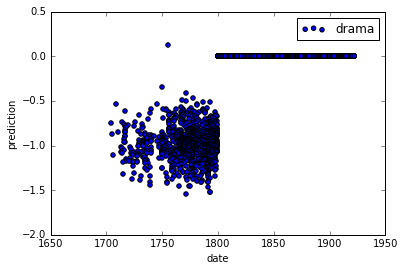

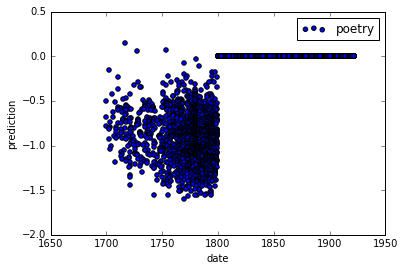

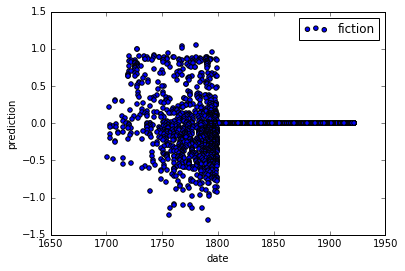

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

for genre, metadata in trav_metadatas.items():
    metadata.plot(kind='scatter', x='date', y='prediction', label=genre)

# Plotting Means by Year
Another way to look at change over time is to consider the annual mean philosophical value for each genre. In other words, we look at the average of all the classifier predictions by year, and then comapre by genre.

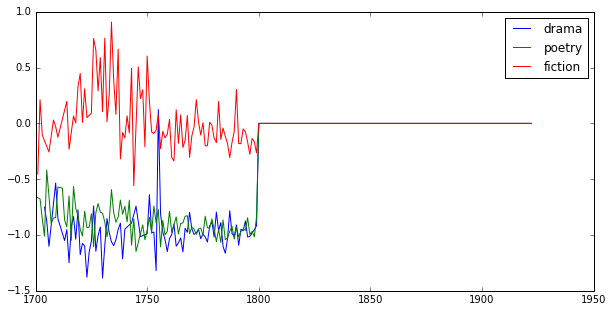

In [13]:
plt.figure(figsize=(10,5))
for genre, metadata in trav_metadatas.items():
    values = {}
    for key, grp in metadata.groupby(['date']):
        values[key] = grp['prediction'].mean()
    plt.plot(list(values.keys()), list(values.values()), label=genre)
plt.legend(trav_metadatas.keys())
plt.show()

I haven't had the chance to think through these yet, but I am glad to see they are working - and, more importantly, very intrigued by the results!